In [162]:

from pyfiglet import Figlet

f_f = Figlet(font='slant')
print(f_f.renderText('Its all about AI and crypto now'))

    ______                ____         __                __     ___    ____
   /  _/ /______   ____ _/ / /  ____ _/ /_  ____  __  __/ /_   /   |  /  _/
   / // __/ ___/  / __ `/ / /  / __ `/ __ \/ __ \/ / / / __/  / /| |  / /  
 _/ // /_(__  )  / /_/ / / /  / /_/ / /_/ / /_/ / /_/ / /_   / ___ |_/ /   
/___/\__/____/   \__,_/_/_/   \__,_/_.___/\____/\__,_/\__/  /_/  |_/___/   
                                                                           
                   __                         __                              
  ____ _____  ____/ /  ____________  ______  / /_____     ____  ____ _      __
 / __ `/ __ \/ __  /  / ___/ ___/ / / / __ \/ __/ __ \   / __ \/ __ \ | /| / /
/ /_/ / / / / /_/ /  / /__/ /  / /_/ / /_/ / /_/ /_/ /  / / / / /_/ / |/ |/ / 
\__,_/_/ /_/\__,_/   \___/_/   \__, / .___/\__/\____/  /_/ /_/\____/|__/|__/  
                              /____/_/                                        



## Etherium prediction with Artificial Intelligence (Deep Learning via LSTM Neural Networks)

In [163]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


Importerar dom bibliotek som krävs.

In [1]:
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

2024-04-25 12:24:44.140200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 12:25:05.519206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Via API på Coingecko som är en kryptosida har jag laddat med data från 2018-01-01 till 2022-12-31. Pga av begränsningar i API:et har det laddats ner till 5 st. csv-filer. 

#### Observera att filen API_call.py inte gå att köra igen då API:et med min API-key inte längre är "valid" för att hämta datan igen. Jag måste uppgradera till en högre "pay-plan" för att ladda ner nu.

Importerar dom 5 csv-filerna som redan finns nerladdade från körning av filen API_call.py till en csv-fil som heter "sammanslagen_data.csv


In [165]:

# Ange sökvägarna till CSV-filerna
file_paths = ['./csv/prices_2018.csv', './csv/prices_2019.csv', "./csv/prices_2020.csv", './csv/prices_2021.csv', './csv/prices_2022.csv']

# Skapa en tom DataFrame för att hålla den sammanslagna datan
combined_data = pd.DataFrame()

# Loopa igenom varje sökväg och lägg till dess innehåll till den sammanslagna DataFramen
for file_path in file_paths:
    df = pd.read_csv(file_path)
    combined_data = pd.concat([combined_data, df], ignore_index=True)

 # Skriv den sammanslagna datan till en ny CSV-fil
combined_data.to_csv('sammanslagen_data.csv', index=False)

print("Sammanslagen data har sparats till sammanslagen_data.csv")

Sammanslagen data har sparats till sammanslagen_data.csv


In [166]:
# Läs in data från CSV-filen
data = pd.read_csv("./csv/sammanslagen_data.csv")

# Välj endast kolumnerna 'Date' och 'Price'. I ovan valda csv-fil finns enbart columnerna Date och Price
data = data.loc[:,['Date','Price']]

# Skriver ut de första fem raderna av den nya dataramen
print(data.head(5))


         Date  Price
0  2018-01-01   6345
1  2018-01-02   7155
2  2018-01-03   7879
3  2018-01-04   7959
4  2018-01-05   8199


In [167]:
data.columns

Index(['Date', 'Price'], dtype='object')

In [168]:
data.dtypes

Date     object
Price     int64
dtype: object

In [169]:
data.head


<bound method NDFrame.head of             Date  Price
0     2018-01-01   6345
1     2018-01-02   7155
2     2018-01-03   7879
3     2018-01-04   7959
4     2018-01-05   8199
...          ...    ...
1820  2022-12-27  12867
1821  2022-12-28  12698
1822  2022-12-29  12438
1823  2022-12-30  12567
1824  2022-12-31  12503

[1825 rows x 2 columns]>

Ovan kan ses att datasettet har 1825 rader och 2 kolumner.

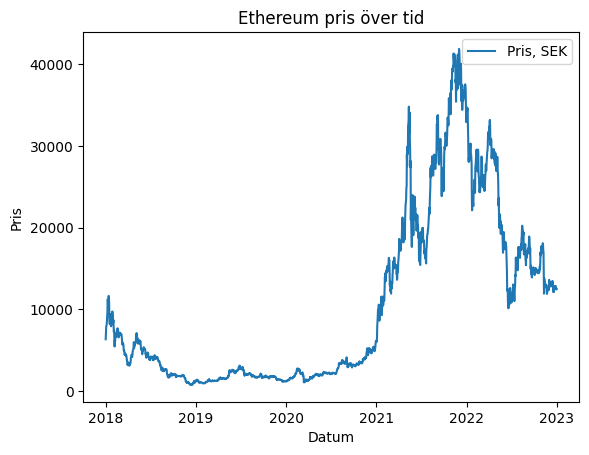

In [170]:
# Konvertera datumkolumnen till pandas datetime-objekt
data['Date'] = pd.to_datetime(data['Date'])
# Plotta datan
plt.plot(data['Date'], data['Price'], label='Pris, SEK')
plt.xlabel('Datum')
plt.ylabel('Pris')
plt.title('Ethereum pris över tid')

plt.legend()
plt.show()

In [171]:
# Ställer in kolumnen 'Date' som index
data = data.set_index('Date')

# Konverterar indexet till ett DateTimeIndex-objekt
data.index = pd.to_datetime(data.index,unit='ns')

# Skriv ut det nya indexet
print(data.index)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=1825, freq=None)


In [172]:
# Tilldelar strängen 'Price'(2:a kolumnen i datasettet) till variabeln aim
# aim variabeln kan sedan användas för att referera till kolumnen 'Price'

aim='Price'

In [173]:
# Jag delar upp mitt datasett i en träningssekvens och en testsekvens samt definierar en funktion 'line_plot' 
# för att rita en linjediagram. 

train_data = data.iloc[:1450]
test_data = data.iloc[1450:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('ETHEREUM', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8)) 

In [174]:
# Printar ut train_data för att se att det ser okey ut.
print(train_data)

            Price
Date             
2018-01-01   6345
2018-01-02   7155
2018-01-03   7879
2018-01-04   7959
2018-01-05   8199
...           ...
2021-12-17  35881
2021-12-18  35540
2021-12-19  36382
2021-12-20  35897
2021-12-21  36135

[1450 rows x 1 columns]


In [175]:
# Printar ut test_data för att se att det också ser okey ut.
print(test_data)

            Price
Date             
2021-12-22  36854
2021-12-23  36282
2021-12-24  37388
2021-12-25  37017
2021-12-26  37523
...           ...
2022-12-27  12867
2022-12-28  12698
2022-12-29  12438
2022-12-30  12567
2022-12-31  12503

[375 rows x 1 columns]


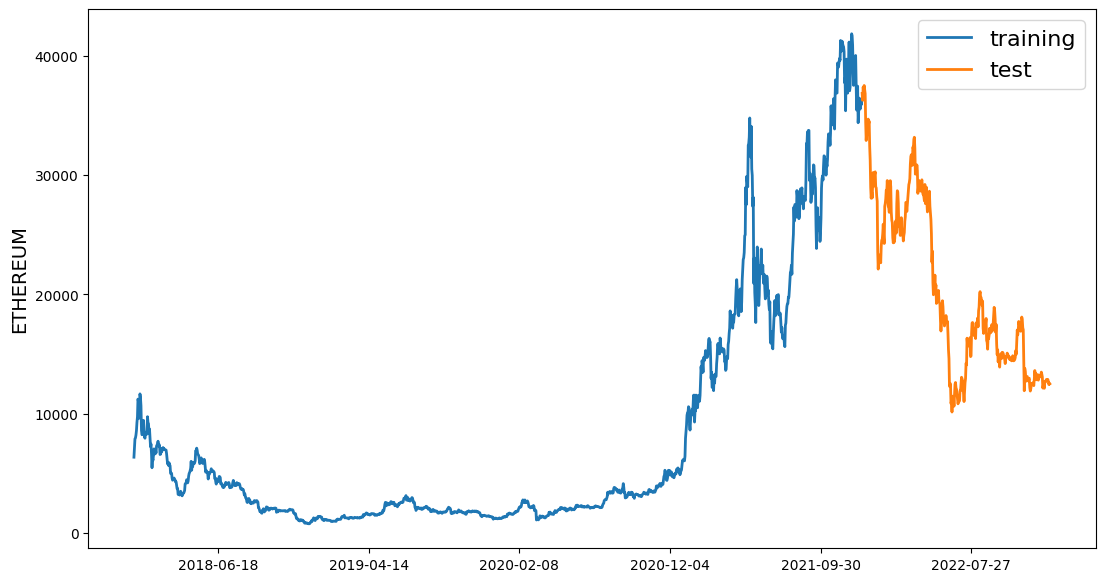

In [176]:
# Plottar ut en kurva över träningsdata och testdata med hjälp av funktionen 'line_plot'.
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

### Normalisering av data. 
Normalisering är en vanlig förbehandlingsteknik inom maskininlärning för att skala data till ett gemensamt intervall eller en gemensam fördelning, vilket kan förbättra prestanda och konvergens för många algoritmer. 

In [177]:
# Denna funktion normaliserar data så att den första punkten blir noll och sedan beräknar avvikelserna 
# från denna baslinje. Detta innebär att den första datapunkten i varje serie blir 0 och alla andra punkter 
# representerar en relativ förändring från den första punkten.

# Varje värde i dataserien divideras med det första värdet i serien. Sedan dras -1 av. Detta leder till att det första värdet 
# blir 0 och alla andra värden representerar den relativa förändringen från det första värdet.
def normalise_zero_base(ethereum_series):
    return ethereum_series / ethereum_series.iloc[0] - 1


# Denna funktion normaliserar data till intervallet [0, 1] genom att skala varje värde baserat på det minsta och största värdet i datamängden.
def normalise_min_max(ethereum_series):
    return (ethereum_series - ethereum_series.min()) / (data.max() - ethereum_series.min())

In [178]:
#  Denna funktion extraherar fönster av data från en serie av Ethereum-priser, normaliserar varje fönster om det behövs, 
# och returnerar en uppsättning av dessa fönster som en numpy-array för användning i en LSTM-modell.
def extract_window_data(ethereum_series, window_len=5, zero_base=True):
    window_data = []
    for start_idx in range(len(ethereum_series) - window_len):
        window_prices = ethereum_series[start_idx: (start_idx + window_len)].copy()
        if zero_base:
            window_prices = normalise_zero_base(window_prices)
        window_data.append(window_prices.values)
    return np.array(window_data)



In [179]:
# Funktionen 'prepare_data' förbereder data för att träna och testa LSTM-modellen.
# Funktionen använder 'extract_window_data' för att extrahera fönster av data från tränings- och testdatamängderna (train_data och test_data). 
def prepare_data(aim, window_len=10, zero_base=True):
    train_window_data = extract_window_data(train_data, window_len, zero_base)
    test_window_data = extract_window_data(test_data, window_len, zero_base)
    train_target_values = train_data[aim][window_len:].values
    test_target_values = test_data[aim][window_len:].values
    if zero_base:
        train_target_values = train_target_values / train_data[aim][:-window_len].values - 1
        test_target_values = test_target_values / test_data[aim][:-window_len].values - 1

    return train_data, test_data, train_window_data, test_window_data, train_target_values, test_target_values

In [180]:

# en funktion som förbereder data för framtida användning i en maskininlärningsmodell.
# OBS!!!! OSÄKER PÅ OM JAG KOMMER INKLUDERA DENNA FUNKTION!!!
def prepare_future_data(aim, window_len=10, zero_base=True, future_data=None):
    if future_data is None:
        return None, None
    
    future_window_data = extract_window_data(future_data, window_len, zero_base)
    future_target_values = future_data[aim][window_len:].values
    if zero_base:
        future_target_values = future_target_values / future_data[aim][:-window_len].values - 1
    
    return future_window_data, future_target_values

In [181]:
# Nedan funktion bygger en LSTM-modell (Long Short-Term Memory) 
# och returnerar en kompilerad LSTM-modell.

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout)) # Lägger till dropout-lager för att förhindra överanpassning genom att slumpmässigt stänga av ett visst antal noder under träning.
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model #Returnerar den kompilerade modellen för användning.
np.random.seed(245) # Samma sekvens av slumpmässiga tal att genereras varje gång koden körs, förutsatt att alla andra förhållanden förblir desamma.
window_len = 5
zero_base = True
lstm_neurons = 50 # Antalet neuroner i ett LSTM-lager är en hyperparameter som kan justeras för att påverka modellens kapacitet och inlärningsförmåga.
epochs = 20
batch_size = 32
loss = 'mse' # Förlustfunktionen Mean Squared Error (MSE), vilket är en vanlig förlustfunktion för regressionsproblem.
dropout = 0.24 # Dropout är en regleringsteknik som används för att förhindra överanpassning i neurala nätverk genom att slumpmässigt "stänga av" (sätta noll) ett visst antal noder under träningen.
optimizer = 'adam' # Adam (Adaptive Moment Estimation)
train_data, test_data, train_window_data, test_window_data, train_target_values, test_target_values = prepare_data(aim,window_len, zero_base)
     

print(train_window_data.shape), nedan, kommer visa de faktiska dimensionerna på  träningsdatan och ge en uppfattning om storleken på träningsdatan. Detta är användbart för att kontrollera att datan har rätt form och storlek innan den matas in i  modellen.

In [182]:
print(train_window_data.shape)

(1445, 5, 1)


### (1445, 5, 1) betyder följande:

Det finns totalt 1445 tidsfönster.
Varje tidsfönster har 5 tidssteg.
Varje tidssteg har 1 funktion (variabel).
Jag har 1445 exempel av tidssekvensdata för träning, där varje exempel består av en sekvens av 5 tidssteg, och varje tidssteg innehåller endast en variabel.

Detta är den form man förväntar sig att träningsdata ska ha för att matas in i en LSTM-modell. Varje tidsfönster representerar en sekvens av datapunkter över tid, och LSTM-modellen kommer att träna på dessa sekvenser för att göra förutsägelser.

In [183]:
# Bygger LSTM-modellen med de specificerade parametrarna
model = build_lstm_model(
    train_window_data, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

# Tränar modellen med träningsdata och validerar den med testdata
modelfit = model.fit(
    train_window_data, train_target_values, validation_data=(test_window_data, test_target_values), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0118 - val_loss: 0.0047
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

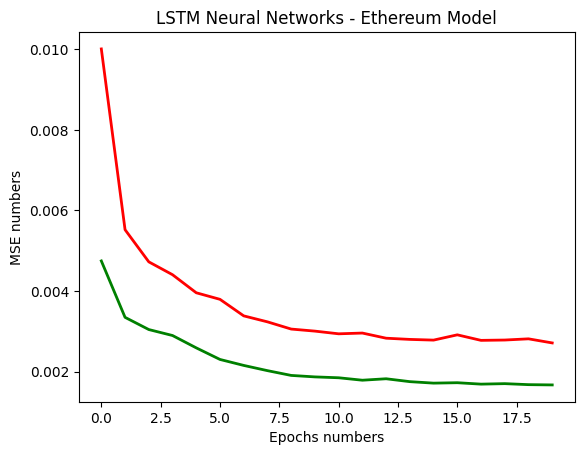

In [184]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - Ethereum Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [185]:
# Importera modulen för att spara modellen
from tensorflow.keras.models import save_model

# Ange sökvägen för att spara modellen och filnamnet
model_path = "my_model.keras"

# Spara modellen som en keras-fil
save_model(model, model_path)

print("Modellen har sparats som en Keras-fil på sökvägen:", model_path)



Modellen har sparats som en Keras-fil på sökvägen: my_model.keras


Medelabsolutfelet (MAE) mellan modellens förutsägelser och de verkliga målen. Detta är ett vanligt sätt att utvärdera en regressionsmodells prestanda.

In [186]:
#Skapa en serie 'targets' som innehåller de verkliga målen från testdatan 'test_data'
targets = test_data[aim][window_len:]
#Använder den tränade modellen för att göra förutsägelser på testdatan test_window_data. "squeeze" (flattar) ut resultaten till en endimensionell array.
preds_model_predicted = model.predict(test_window_data).squeeze()
preds_model_predicted = pd.Series(index=targets.index, data=preds_model_predicted)
#Beräknar medelvärdet av absolutvärdet av skillnaden mellan förutsägelserna preds och de verkliga målen test_target_values. Detta ger MAE mellan modellens förutsägelser och de verkliga målen på testdatan.
mean_absolute_error(preds_model_predicted, test_target_values)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


0.03020854689540303

Medelkvadratfelet (MSE=mean squared error) mellan modellens förutsägelser och de verkliga målen på testdatan. MSE är en annan vanlig måttstock för att utvärdera prestanda hos en regressionsmodell, och det mäter genomsnittet av kvadraten på skillnaden mellan varje förutsagt värde och det faktiska värdet.

Det är en bra praxis att använda både MSE och MAE för att utvärdera prestanda hos en regressionsmodell, eftersom de båda ger olika aspekter av modellens fel. MSE ger mer vikt åt stora fel på grund av kvadreringen, medan MAE ger en bättre uppfattning om genomsnittlig absolut felstorlek.

In [187]:
#Beräknar medelvärdet av kvadraten av skillnaden mellan varje element i preds (modellens förutsägelser) och motsvarande element i 
# test_target_values (de verkliga målen på testdatan). Detta ger dig MSE mellan modellens förutsägelser och de verkliga målen.
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds_model_predicted, test_target_values)
SCORE_MSE

0.001714736578001914

R2-score, förklaringsgraden, är ett användbart verktyg för att bedöma modellens prestanda. R2-score är ett mått på hur väl den beroende variabeln förklaras av den oberoende variabeln i modellen. Det ger en indikation på hur bra modellen passar dina data jämfört med en enkel genomsnittsmodell.

In [188]:
from sklearn.metrics import r2_score
r2_score=r2_score(test_target_values, preds_model_predicted)
r2_score*100

81.41811501329603

Date
2021-12-27    0.013872
2021-12-28    0.022072
2021-12-29   -0.016532
2021-12-30   -0.064656
2021-12-31   -0.124007
                ...   
2022-12-27    0.012630
2022-12-28    0.006165
2022-12-29   -0.013335
2022-12-30   -0.033863
2022-12-31   -0.026510
Length: 370, dtype: float32


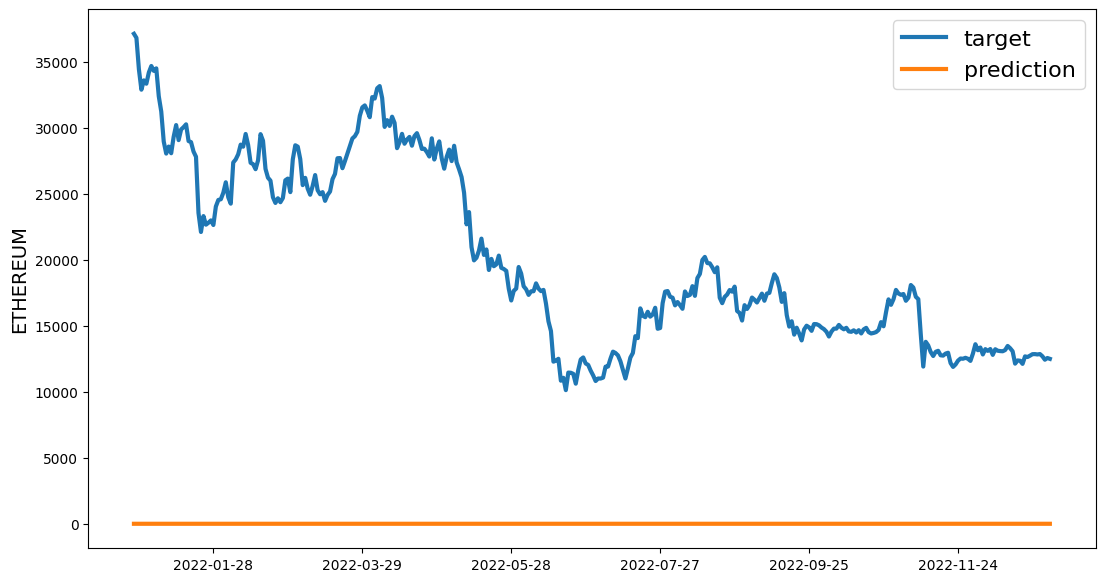

In [189]:
#preds_model_predicted = test_data[aim].values[:-window_len] * (preds_model_predicted + 1)
#print(preds_model_predicted)  
#preds_model_predicted = pd.Series(index=targets.index, data=preds_model_predicted)
print(preds_model_predicted)
line_plot(targets, preds_model_predicted, 'target', 'prediction', lw=3)

In [190]:
print(targets.index[-1])

2022-12-31 00:00:00


In [191]:
print(preds_model_predicted.index[-1])

2022-12-31 00:00:00


In [192]:
from datetime import datetime

# Skapa ett datetime-objekt för det specifika datumet
specifikt_datum = datetime(2022, 1, 1).date()

# Omvandla specifikt_datum till ett strängformat som matchar indexformatet i preds
specifikt_datum_str = specifikt_datum.strftime('%Y-%m-%d')

# Komma åt värdet för det specifika datumet i preds
pred_värde_för_specifikt_datum = preds_model_predicted.loc[specifikt_datum_str]
print(f"Värdet för det prediktade datumet, {specifikt_datum_str} är:", int(pred_värde_för_specifikt_datum),'SEK')

# Komma åt värdet för det specifika datumet i targets
target_värde_för_specifikt_datum = targets.loc[specifikt_datum_str]
print(f"Värdet för target datumet,{specifikt_datum_str} är:", target_värde_för_specifikt_datum,'SEK')




Värdet för det prediktade datumet, 2022-01-01 är: 0 SEK
Värdet för target datumet,2022-01-01 är: 33362 SEK
